In [1]:
!rm /content/News_CSVs

rm: cannot remove '/content/News_CSVs': No such file or directory


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
!ln -s "/content/drive/MyDrive/News_CSVs"

Mounted at /content/drive


In [3]:
import os
import string
import re
import nltk
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.0'
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [50.4 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,617 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,309 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/

# Importing data and exploration

In [4]:
# Dependencies
import pandas as pd
import numpy as np
import nltk, string,re
from string import punctuation
from nltk.corpus import stopwords
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, lit, col, to_date, rand, lower

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Research Question:



# Data:

The dataset can be found and dowloaded from the following link  https://www.kaggle.com/datasets/rajatkumar30/fake-news

In [5]:
#Load the dataset into a PySpark DataFrame
fake_df = spark.read.csv("/content/News_CSVs/fake.csv", header=True, inferSchema=True)
fake_df.show()


+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|
| Papa John’s Foun...|A centerpiece of ...|   News|December 21, 2017|
| WATCH: Paul Ryan..

In [6]:
fake_df.count()

23489

In [7]:
true_df = spark.read.csv("/content/News_CSVs/true.csv", header=True, inferSchema=True)
true_df.show()


+--------------------+--------------------+--------------------+------------------+
|               title|                text|             subject|              date|
+--------------------+--------------------+--------------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|        politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|        politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|        politicsNews|December 29, 2017 |
|White House, Cong...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |
|Trump says Russia...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |
|Factbox: Trump on...|The following sta...|        politicsNews|December 29, 2017 |
|Trump on Twitter ...|The following sta...|        politicsNews|December 29,

In [8]:
true_df.count()

21417

# Data cleaning

In [9]:
# Display the schema of the fake dataframe
print("Fake DataFrame Schema:")
fake_df.printSchema()

# Display the schema of the true dataframe
print("\nReal DataFrame Schema:")
true_df.printSchema()

Fake DataFrame Schema:
root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)


Real DataFrame Schema:
root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



In [10]:
fake_df = fake_df.dropna(how='any')


In [11]:
fake_df.count()

23481

In [12]:
true_df = true_df.dropna(how='any')

In [13]:
true_df.count()

21417

In [14]:
# Add a new column named 'label' with value 'fake' to the fake dataframe
fake_df = fake_df.withColumn('label', lit('0'))

# Add a new column named 'label' with value 'real' to the real dataframe
true_df = true_df.withColumn('label', lit('1'))

In [15]:
# Merge datasets
news_data_df = fake_df.unionByName(true_df)

# show the concatenated dataframe
news_data_df.show()

+--------------------+--------------------+-------+-----------------+-----+
|               title|                text|subject|             date|label|
+--------------------+--------------------+-------+-----------------+-----+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|    0|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|    0|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|    0|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|    0|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|    0|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|    0|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|    0|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|    0|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|    0|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|    0|
| Papa John’

In [16]:
#Random Shuffling the dataframe
news_data_df = news_data_df.orderBy(rand())
news_data_df.show()


+--------------------+--------------------+---------------+-------------------+-----+
|               title|                text|        subject|               date|label|
+--------------------+--------------------+---------------+-------------------+-----+
| Comedy Central’s...|Comedy Central s ...|           News|    August 28, 2016|    0|
|Florida lawmaker ...|(Reuters) - U.S. ...|   politicsNews|     June 17, 2016 |    1|
|BREAKING: Philipp...|                    |Government News|       Oct 20, 2016|    0|
| WATCH: GOP-Frien...|A PAC that claims...|           News|      June 18, 2017|    0|
| RNC Chaos Contin...|Donald Trump s co...|           News|      July 18, 2016|    0|
|Tax bill's 'pass-...|WASHINGTON (Reute...|   politicsNews| December 20, 2017 |    1|
|China says to ban...|SHANGHAI (Reuters...|   politicsNews|September 23, 2017 |    1|
|Obama's not-so-se...|WASHINGTON (Reute...|   politicsNews| November 22, 2016 |    1|
|Saudi calls for s...|(Reuters) - Saudi...|      world

In [17]:
#combine data
from pyspark.sql.functions import concat_ws
news_data_df = news_data_df.withColumn('news', concat_ws(" ", news_data_df.title, news_data_df.text))

In [18]:
news_data_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- label: string (nullable = false)
 |-- news: string (nullable = false)



In [19]:
#Drop extra column
news_data_df = news_data_df.drop('title').drop('text').drop('date')
news_data_df.show()

+---------------+-----+--------------------+
|        subject|label|                news|
+---------------+-----+--------------------+
|           News|    0| Comedy Central’s...|
|   politicsNews|    1|Florida lawmaker ...|
|Government News|    0|BREAKING: Philipp...|
|           News|    0| WATCH: GOP-Frien...|
|           News|    0| RNC Chaos Contin...|
|   politicsNews|    1|Tax bill's 'pass-...|
|   politicsNews|    1|China says to ban...|
|   politicsNews|    1|Obama's not-so-se...|
|      worldnews|    1|Saudi calls for s...|
|   politicsNews|    1|Stung by criticis...|
|           News|    0| Alabama’s Chief ...|
|   politicsNews|    1|Trump's Treasury ...|
|       politics|    0|3 PEOPLE LINE UP ...|
|   politicsNews|    1|Trump nominee for...|
|      worldnews|    1|Red Cross says st...|
|      worldnews|    1|Grounded ferry in...|
|       politics|    0|SHOCKING VIDEO Sh...|
|   politicsNews|    1|House speaker opt...|
|        US_News|    0|US Advising Soldi...|
|   politi

In [20]:
# convert to lowercase
news_data_df = news_data_df.withColumn('news', lower(col('news')))
news_data_df.show()


+---------------+-----+--------------------+
|        subject|label|                news|
+---------------+-----+--------------------+
|           News|    0| comedy central’s...|
|   politicsNews|    1|florida lawmaker ...|
|Government News|    0|breaking: philipp...|
|           News|    0| watch: gop-frien...|
|           News|    0| rnc chaos contin...|
|   politicsNews|    1|tax bill's 'pass-...|
|   politicsNews|    1|china says to ban...|
|   politicsNews|    1|obama's not-so-se...|
|      worldnews|    1|saudi calls for s...|
|   politicsNews|    1|stung by criticis...|
|           News|    0| alabama’s chief ...|
|   politicsNews|    1|trump's treasury ...|
|       politics|    0|3 people line up ...|
|   politicsNews|    1|trump nominee for...|
|      worldnews|    1|red cross says st...|
|      worldnews|    1|grounded ferry in...|
|       politics|    0|shocking video sh...|
|   politicsNews|    1|house speaker opt...|
|        US_News|    0|us advising soldi...|
|   politi

In [21]:
# Convert in to pandas
news_data_pd_df = news_data_df.toPandas()

news_data_pd_df

,subject,label,news
0,News,0,comedy central’s roast of rob lowe hijacked a...
1,politicsNews,1,florida lawmaker drops senate bid to make way ...
2,Government News,0,breaking: philippines president announces ‘sep...
3,News,0,watch: gop-friendly pac creates sickening lin...
4,News,0,rnc chaos continues as top fundraiser resigns...
...,...,...,...
44893,politics,0,trump reportedly thinking about replacing jeff...
44894,Middle-east,0,dallas maidan: staged snipers designed to infl...
44895,politicsNews,1,"'you were my guy,' trump told macron, french o..."
44896,News,0,george takei just shook washington to its cor...


# Let's remove URLs

In [22]:
# Remove urls
def urls_remove(text):
    pattern_url = re.compile(r'(https?://\S+)|(www\.\S+)|(\S+\.\S+/\S+)')
    return pattern_url.sub(r'', text)

news_data_pd_df['urlsRemoved'] = news_data_pd_df['news'].apply(urls_remove)

news_data_pd_df

,subject,label,news,urlsRemoved
0,News,0,comedy central’s roast of rob lowe hijacked a...,comedy central’s roast of rob lowe hijacked a...
1,politicsNews,1,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid to make way ...
2,Government News,0,breaking: philippines president announces ‘sep...,breaking: philippines president announces ‘sep...
3,News,0,watch: gop-friendly pac creates sickening lin...,watch: gop-friendly pac creates sickening lin...
4,News,0,rnc chaos continues as top fundraiser resigns...,rnc chaos continues as top fundraiser resigns...
...,...,...,...,...
44893,politics,0,trump reportedly thinking about replacing jeff...,trump reportedly thinking about replacing jeff...
44894,Middle-east,0,dallas maidan: staged snipers designed to infl...,dallas maidan: staged snipers designed to infl...
44895,politicsNews,1,"'you were my guy,' trump told macron, french o...","'you were my guy,' trump told macron, french o..."
44896,News,0,george takei just shook washington to its cor...,george takei just shook washington to its cor...


In [23]:
#Remove all special characters.
def remove_special_chars(text):
    pattern = r'[^\w\s]' #([^\w\s] matches any character that is not a word character (\w) or whitespace (\s), which includes emoticons, symbols & pictographs, transport & map symbols, flags (iOS), other miscellaneous symbols, enclosed characters.)
    return re.sub(pattern, '', text)
news_data_pd_df['specialcharRemoved'] = news_data_pd_df['urlsRemoved'].apply(remove_special_chars)
news_data_pd_df

,subject,label,news,urlsRemoved,specialcharRemoved
0,News,0,comedy central’s roast of rob lowe hijacked a...,comedy central’s roast of rob lowe hijacked a...,comedy centrals roast of rob lowe hijacked as...
1,politicsNews,1,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid to make way ...
2,Government News,0,breaking: philippines president announces ‘sep...,breaking: philippines president announces ‘sep...,breaking philippines president announces separ...
3,News,0,watch: gop-friendly pac creates sickening lin...,watch: gop-friendly pac creates sickening lin...,watch gopfriendly pac creates sickening link ...
4,News,0,rnc chaos continues as top fundraiser resigns...,rnc chaos continues as top fundraiser resigns...,rnc chaos continues as top fundraiser resigns...
...,...,...,...,...,...
44893,politics,0,trump reportedly thinking about replacing jeff...,trump reportedly thinking about replacing jeff...,trump reportedly thinking about replacing jeff...
44894,Middle-east,0,dallas maidan: staged snipers designed to infl...,dallas maidan: staged snipers designed to infl...,dallas maidan staged snipers designed to infli...
44895,politicsNews,1,"'you were my guy,' trump told macron, french o...","'you were my guy,' trump told macron, french o...",you were my guy trump told macron french offic...
44896,News,0,george takei just shook washington to its cor...,george takei just shook washington to its cor...,george takei just shook washington to its cor...


# Let's remove stopwords like is,a,the... Which do not offer much insight.

In [24]:
# Remove all stop word
def stopword(text):
   stop_words = set(stopwords.words('english'))
   return " ".join([word for word in text.split() if word not in stop_words])

news_data_pd_df['stopWordRemoved'] = news_data_pd_df['specialcharRemoved'].apply(stopword)
news_data_pd_df

,subject,label,news,urlsRemoved,specialcharRemoved,stopWordRemoved
0,News,0,comedy central’s roast of rob lowe hijacked a...,comedy central’s roast of rob lowe hijacked a...,comedy centrals roast of rob lowe hijacked as...,comedy centrals roast rob lowe hijacked comedi...
1,politicsNews,1,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid make way rub...
2,Government News,0,breaking: philippines president announces ‘sep...,breaking: philippines president announces ‘sep...,breaking philippines president announces separ...,breaking philippines president announces separ...
3,News,0,watch: gop-friendly pac creates sickening lin...,watch: gop-friendly pac creates sickening lin...,watch gopfriendly pac creates sickening link ...,watch gopfriendly pac creates sickening link g...
4,News,0,rnc chaos continues as top fundraiser resigns...,rnc chaos continues as top fundraiser resigns...,rnc chaos continues as top fundraiser resigns...,rnc chaos continues top fundraiser resigns con...
...,...,...,...,...,...,...
44893,politics,0,trump reportedly thinking about replacing jeff...,trump reportedly thinking about replacing jeff...,trump reportedly thinking about replacing jeff...,trump reportedly thinking replacing jeff sessi...
44894,Middle-east,0,dallas maidan: staged snipers designed to infl...,dallas maidan: staged snipers designed to infl...,dallas maidan staged snipers designed to infli...,dallas maidan staged snipers designed inflict ...
44895,politicsNews,1,"'you were my guy,' trump told macron, french o...","'you were my guy,' trump told macron, french o...",you were my guy trump told macron french offic...,guy trump told macron french official says bru...
44896,News,0,george takei just shook washington to its cor...,george takei just shook washington to its cor...,george takei just shook washington to its cor...,george takei shook washington core reason make...


# Lemmatization
Lemmatization to bring back multiple forms of same word to their common root like 'coming', 'comes' into 'come'.

In [25]:
# Define the lemmatization function
def lemmatize_text(text):
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])

news_data_pd_df['lemmatized_Rows'] = news_data_pd_df['stopWordRemoved'].apply(lemmatize_text)

news_data_pd_df

,subject,label,news,urlsRemoved,specialcharRemoved,stopWordRemoved,lemmatized_Rows
0,News,0,comedy central’s roast of rob lowe hijacked a...,comedy central’s roast of rob lowe hijacked a...,comedy centrals roast of rob lowe hijacked as...,comedy centrals roast rob lowe hijacked comedi...,comedy central roast rob lowe hijacked comedia...
1,politicsNews,1,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid make way rub...,florida lawmaker drop senate bid make way rubi...
2,Government News,0,breaking: philippines president announces ‘sep...,breaking: philippines president announces ‘sep...,breaking philippines president announces separ...,breaking philippines president announces separ...,breaking philippine president announces separa...
3,News,0,watch: gop-friendly pac creates sickening lin...,watch: gop-friendly pac creates sickening lin...,watch gopfriendly pac creates sickening link ...,watch gopfriendly pac creates sickening link g...,watch gopfriendly pac creates sickening link g...
4,News,0,rnc chaos continues as top fundraiser resigns...,rnc chaos continues as top fundraiser resigns...,rnc chaos continues as top fundraiser resigns...,rnc chaos continues top fundraiser resigns con...,rnc chaos continues top fundraiser resigns con...
...,...,...,...,...,...,...,...
44893,politics,0,trump reportedly thinking about replacing jeff...,trump reportedly thinking about replacing jeff...,trump reportedly thinking about replacing jeff...,trump reportedly thinking replacing jeff sessi...,trump reportedly thinking replacing jeff sessi...
44894,Middle-east,0,dallas maidan: staged snipers designed to infl...,dallas maidan: staged snipers designed to infl...,dallas maidan staged snipers designed to infli...,dallas maidan staged snipers designed inflict ...,dallas maidan staged sniper designed inflict 7...
44895,politicsNews,1,"'you were my guy,' trump told macron, french o...","'you were my guy,' trump told macron, french o...",you were my guy trump told macron french offic...,guy trump told macron french official says bru...,guy trump told macron french official say brus...
44896,News,0,george takei just shook washington to its cor...,george takei just shook washington to its cor...,george takei just shook washington to its cor...,george takei shook washington core reason make...,george takei shook washington core reason make...


# Handling Columns and Tokenizing Data

In [26]:
#Remove all tokens
def remove_tokens(text):
    # Remove repeating characters
    text = re.sub(r'(\w)\1+', r'\1', text)

    # Remove tokens containing digits
    text = re.sub(r'\b\w*\d\w*\b', '', text)

    # Remove tokens containing underscore
    text = re.sub(r'\b\w*_\w*\b', '', text)

    # Remove tokens containing special characters
    text = re.sub(r'\b\w*[^\w\s]+\w*\b', '', text)

    # Remove tokens less than 2 characters
    text = re.sub(r'\b\w{1}\b', '', text)

    return text

news_data_pd_df['final_news'] = news_data_pd_df['lemmatized_Rows'].apply(remove_tokens)

news_data_pd_df

,subject,label,news,urlsRemoved,specialcharRemoved,stopWordRemoved,lemmatized_Rows,final_news
0,News,0,comedy central’s roast of rob lowe hijacked a...,comedy central’s roast of rob lowe hijacked a...,comedy centrals roast of rob lowe hijacked as...,comedy centrals roast rob lowe hijacked comedi...,comedy central roast rob lowe hijacked comedia...,comedy central roast rob lowe hijacked comedia...
1,politicsNews,1,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid to make way ...,florida lawmaker drops senate bid make way rub...,florida lawmaker drop senate bid make way rubi...,florida lawmaker drop senate bid make way rubi...
2,Government News,0,breaking: philippines president announces ‘sep...,breaking: philippines president announces ‘sep...,breaking philippines president announces separ...,breaking philippines president announces separ...,breaking philippine president announces separa...,breaking philipine president anounces separati...
3,News,0,watch: gop-friendly pac creates sickening lin...,watch: gop-friendly pac creates sickening lin...,watch gopfriendly pac creates sickening link ...,watch gopfriendly pac creates sickening link g...,watch gopfriendly pac creates sickening link g...,watch gopfriendly pac creates sickening link g...
4,News,0,rnc chaos continues as top fundraiser resigns...,rnc chaos continues as top fundraiser resigns...,rnc chaos continues as top fundraiser resigns...,rnc chaos continues top fundraiser resigns con...,rnc chaos continues top fundraiser resigns con...,rnc chaos continues top fundraiser resigns con...
...,...,...,...,...,...,...,...,...
44893,politics,0,trump reportedly thinking about replacing jeff...,trump reportedly thinking about replacing jeff...,trump reportedly thinking about replacing jeff...,trump reportedly thinking replacing jeff sessi...,trump reportedly thinking replacing jeff sessi...,trump reportedly thinking replacing jef sesion...
44894,Middle-east,0,dallas maidan: staged snipers designed to infl...,dallas maidan: staged snipers designed to infl...,dallas maidan staged snipers designed to infli...,dallas maidan staged snipers designed inflict ...,dallas maidan staged sniper designed inflict 7...,dalas maidan staged sniper designed inflict s...
44895,politicsNews,1,"'you were my guy,' trump told macron, french o...","'you were my guy,' trump told macron, french o...",you were my guy trump told macron french offic...,guy trump told macron french official says bru...,guy trump told macron french official say brus...,guy trump told macron french oficial say bruse...
44896,News,0,george takei just shook washington to its cor...,george takei just shook washington to its cor...,george takei just shook washington to its cor...,george takei shook washington core reason make...,george takei shook washington core reason make...,george takei shok washington core reason make ...


In [27]:
#Remove extra columns.
clean_news_data_pd_df = news_data_pd_df.drop(['news', 'urlsRemoved', 'specialcharRemoved',  'stopWordRemoved', 'lemmatized_Rows'],axis=1)

clean_news_data_pd_df

,subject,label,final_news
0,News,0,comedy central roast rob lowe hijacked comedia...
1,politicsNews,1,florida lawmaker drop senate bid make way rubi...
2,Government News,0,breaking philipine president anounces separati...
3,News,0,watch gopfriendly pac creates sickening link g...
4,News,0,rnc chaos continues top fundraiser resigns con...
...,...,...,...
44893,politics,0,trump reportedly thinking replacing jef sesion...
44894,Middle-east,0,dalas maidan staged sniper designed inflict s...
44895,politicsNews,1,guy trump told macron french oficial say bruse...
44896,News,0,george takei shok washington core reason make ...


In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [29]:
clean_news_data_pd_df['label']= le.fit_transform(clean_news_data_pd_df['label'])
clean_news_data_pd_df['subject']= le.fit_transform(clean_news_data_pd_df['subject'])
clean_news_data_pd_df

,subject,label,final_news
0,815,0,comedy central roast rob lowe hijacked comedia...
1,820,1,florida lawmaker drop senate bid make way rubi...
2,810,0,breaking philipine president anounces separati...
3,815,0,watch gopfriendly pac creates sickening link g...
4,815,0,rnc chaos continues top fundraiser resigns con...
...,...,...,...
44893,819,0,trump reportedly thinking replacing jef sesion...
44894,814,0,dalas maidan staged sniper designed inflict s...
44895,820,1,guy trump told macron french oficial say bruse...
44896,815,0,george takei shok washington core reason make ...


In [30]:
#Use TfidfVectorizer to add weight to repeated words
Vectorizer = TfidfVectorizer(max_features=100)
X = Vectorizer.fit_transform(clean_news_data_pd_df['final_news']).toarray()
feature_names = Vectorizer.get_feature_names_out()

In [31]:
y = clean_news_data_pd_df[['subject', 'label']]

In [32]:
y

,subject,label
0,815,0
1,820,1
2,810,0
3,815,0
4,815,0
...,...,...
44893,819,0
44894,814,0
44895,820,1
44896,815,0


In [33]:
feature_names[:8000]

array(['acording', 'administration', 'also', 'america', 'american',
       'atack', 'back', 'bil', 'campaign', 'city', 'clinton', 'could',
       'country', 'court', 'day', 'democrat', 'democratic', 'department',
       'donald', 'election', 'even', 'federal', 'first', 'foreign',
       'former', 'get', 'go', 'going', 'government', 'group', 'hilary',
       'house', 'image', 'including', 'know', 'last', 'law', 'leader',
       'like', 'made', 'make', 'many', 'may', 'medium', 'member',
       'milion', 'military', 'month', 'national', 'ned', 'new', 'news',
       'north', 'obama', 'ofice', 'oficial', 'one', 'party', 'people',
       'percent', 'plan', 'police', 'policy', 'political', 'president',
       'presidential', 'public', 'report', 'republican', 'reuters',
       'right', 'rusia', 'rusian', 'said', 'say', 'security', 'senate',
       'since', 'state', 'statement', 'suport', 'take', 'tax', 'think',
       'time', 'told', 'trump', 'two', 'united', 'video', 'vote', 'want',
       'w

In [34]:
X

array([[0.        , 0.        , 0.17929215, ..., 0.        , 0.        ,
        0.278149  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.04629324,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.1065791 , 0.0642934 ,
        0.        ],
       [0.        , 0.1487063 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05358432, ..., 0.        , 0.        ,
        0.22167803]])

In [35]:
X=pd.DataFrame(X, columns = feature_names)

In [36]:
X.shape

(44898, 100)

In [37]:
X

,acording,administration,also,america,american,atack,back,bil,campaign,city,...,vote,want,washington,way,wek,white,woman,world,would,year
0,0.000000,0.000000,0.179292,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.233754,0.000000,0.118432,0.000000,0.000000,0.0,0.000000,0.000000,0.278149
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068770,0.0,0.068206,0.000000,...,0.000000,0.000000,0.000000,0.137288,0.064943,0.000000,0.0,0.000000,0.046293,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.202269,0.000000,0.0,0.000000,0.000000,...,0.195281,0.000000,0.000000,0.000000,0.163435,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.099904,0.000000,0.000000,0.091771,0.0,0.091017,0.000000,...,0.517746,0.090400,0.000000,0.000000,0.086663,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.103263,0.127708,...,0.000000,0.000000,0.000000,0.000000,0.098323,0.101308,0.0,0.000000,0.140175,0.000000
44894,0.055546,0.000000,0.118259,0.227189,0.024266,0.121952,0.078260,0.0,0.025873,0.063995,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.076148,0.0,0.000000,0.035121,0.061155
44895,0.000000,0.000000,0.000000,0.000000,0.000000,0.111625,0.000000,0.0,0.189453,0.000000,...,0.107769,0.000000,0.000000,0.000000,0.000000,0.092933,0.0,0.106579,0.064293,0.000000
44896,0.000000,0.148706,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.132757,0.000000,...,0.000000,0.131856,0.124563,0.000000,0.000000,0.130244,0.0,0.000000,0.000000,0.000000


In [38]:
X= X.reset_index()

y= y.reset_index()

In [39]:
X_new = pd.concat([X,y],axis=1)

In [40]:
X_new

,index,acording,administration,also,america,american,atack,back,bil,campaign,...,way,wek,white,woman,world,would,year,index,subject,label
0,0,0.000000,0.000000,0.179292,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.118432,0.000000,0.000000,0.0,0.000000,0.000000,0.278149,0,815,0
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068770,0.0,0.068206,...,0.137288,0.064943,0.000000,0.0,0.000000,0.046293,0.000000,1,820,1
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2,810,0
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.202269,0.000000,0.0,0.000000,...,0.000000,0.163435,0.000000,0.0,0.000000,0.000000,0.000000,3,815,0
4,4,0.000000,0.000000,0.000000,0.099904,0.000000,0.000000,0.091771,0.0,0.091017,...,0.000000,0.086663,0.000000,0.0,0.000000,0.000000,0.000000,4,815,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,44893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.103263,...,0.000000,0.098323,0.101308,0.0,0.000000,0.140175,0.000000,44893,819,0
44894,44894,0.055546,0.000000,0.118259,0.227189,0.024266,0.121952,0.078260,0.0,0.025873,...,0.000000,0.000000,0.076148,0.0,0.000000,0.035121,0.061155,44894,814,0
44895,44895,0.000000,0.000000,0.000000,0.000000,0.000000,0.111625,0.000000,0.0,0.189453,...,0.000000,0.000000,0.092933,0.0,0.106579,0.064293,0.000000,44895,820,1
44896,44896,0.000000,0.148706,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.132757,...,0.000000,0.000000,0.130244,0.0,0.000000,0.000000,0.000000,44896,815,0


In [41]:
y=X_new['label']

In [42]:
y

0        0
1        1
2        0
3        0
4        0
        ..
44893    0
44894    0
44895    1
44896    0
44897    0
Name: label, Length: 44898, dtype: int64

In [43]:
X=X_new

In [44]:
X=X.drop(['index','label','index'],axis=1)

In [45]:
X

,acording,administration,also,america,american,atack,back,bil,campaign,city,...,want,washington,way,wek,white,woman,world,would,year,subject
0,0.000000,0.000000,0.179292,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.233754,0.000000,0.118432,0.000000,0.000000,0.0,0.000000,0.000000,0.278149,815
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068770,0.0,0.068206,0.000000,...,0.000000,0.000000,0.137288,0.064943,0.000000,0.0,0.000000,0.046293,0.000000,820
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,810
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.202269,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.163435,0.000000,0.0,0.000000,0.000000,0.000000,815
4,0.000000,0.000000,0.000000,0.099904,0.000000,0.000000,0.091771,0.0,0.091017,0.000000,...,0.090400,0.000000,0.000000,0.086663,0.000000,0.0,0.000000,0.000000,0.000000,815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.103263,0.127708,...,0.000000,0.000000,0.000000,0.098323,0.101308,0.0,0.000000,0.140175,0.000000,819
44894,0.055546,0.000000,0.118259,0.227189,0.024266,0.121952,0.078260,0.0,0.025873,0.063995,...,0.000000,0.000000,0.000000,0.000000,0.076148,0.0,0.000000,0.035121,0.061155,814
44895,0.000000,0.000000,0.000000,0.000000,0.000000,0.111625,0.000000,0.0,0.189453,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.092933,0.0,0.106579,0.064293,0.000000,820
44896,0.000000,0.148706,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.132757,0.000000,...,0.131856,0.124563,0.000000,0.000000,0.130244,0.0,0.000000,0.000000,0.000000,815


# Split the data into training and testing datasets by using train_test_split.

In [46]:
#Split Data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

# Create a Logistic Regression Model with the Original Data

In [47]:
#Creating Logisitc Regression

#Initiate Model
model = LogisticRegression(solver = 'lbfgs', random_state=1)

#Fit model using training Data
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [48]:
#Make Predictions
predictions = model.predict(X_test)

In [49]:
#Evaluating Model Performance
print(balanced_accuracy_score(y_test, predictions))

0.9762734413567831


In [50]:
#Generate a confusion matrix for the model
cm = confusion_matrix(y_test, predictions)
cm

array([[5792,  147],
       [ 120, 5166]])

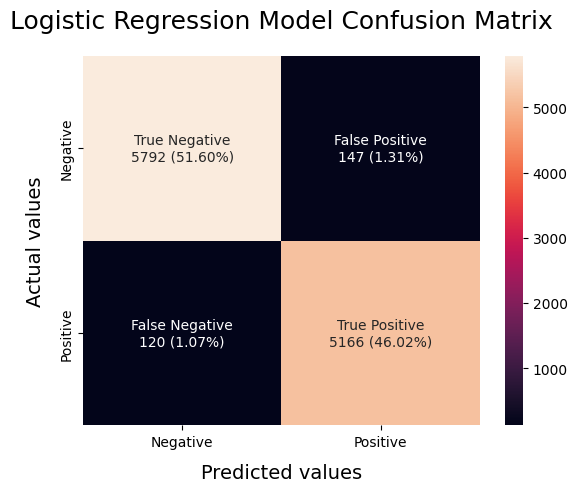

In [51]:
# Create heatmap
def makeCM_Matrix(cm_matrix, title):

  categories = ['Negative','Positive']

  group_names = ['True Negative','False Positive', 'False Negative','True Positive']

  group_percentages = ['{0:.2%}'.format(value) for value in cm_matrix.flatten() / np.sum(cm_matrix)]

  labels = [f'{v1}\n{v2} ({v3})' for v1, v2 ,v3 in zip(group_names,cm_matrix.flatten(),group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cm_matrix, annot = labels,fmt = '',
  xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title (f"{title} Confusion Matrix", fontdict = {'size':18}, pad = 20)
  plt.show()

makeCM_Matrix(cm_matrix=cm, title='Logistic Regression Model')

In [52]:
#Printing Classification Report for the model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5939
           1       0.97      0.98      0.97      5286

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



  The logidtic regression model predicts the 0(Fake news) label correctly 98% of the time and recall of 98%, but the 1 (True news) label with precision of 97% and recall of 98%.

# Predict a Logistic Regression Model with Resampled Training Data

In [53]:
# Using RandomOverSampler to Resample Training Data
from imblearn.over_sampling import RandomOverSampler

#Assigning random_state parameter of 1 to the model
random_samp = RandomOverSampler(random_state = 1)

#Fitting Original training Data to the random_oversampler model
X_res, y_res = random_samp.fit_resample(X_train, y_train)

In [54]:
# Count the distinct values of the resampled labels data
y_res.value_counts()

1    17542
0    17542
Name: label, dtype: int64

In [55]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
res_model = LogisticRegression(solver='lbfgs', random_state=1)

# Fit the model using the resampled training data
res_model.fit(X_res, y_res)

# Make a prediction using the testing data
res_prediction = res_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
print(balanced_accuracy_score(y_test, res_prediction))

0.9670903619258908


In [57]:
#Generate Confusion matrix fro the model
confusion = confusion_matrix(y_test, res_prediction)
confusion

array([[5720,  219],
       [ 153, 5133]])

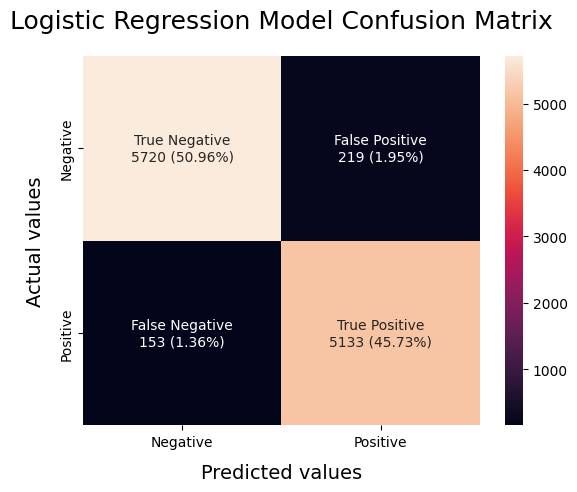

In [58]:
# Create heatmap
def makeCM_Matrix(cm_matrix, title):

  categories = ['Negative','Positive']

  group_names = ['True Negative','False Positive', 'False Negative','True Positive']

  group_percentages = ['{0:.2%}'.format(value) for value in cm_matrix.flatten() / np.sum(cm_matrix)]

  labels = [f'{v1}\n{v2} ({v3})' for v1, v2 ,v3 in zip(group_names,cm_matrix.flatten(),group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cm_matrix, annot = labels,fmt = '',
  xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title (f"{title} Confusion Matrix", fontdict = {'size':18}, pad = 20)
  plt.show()

makeCM_Matrix(cm_matrix=confusion, title='Logistic Regression Model')

In [59]:
print(classification_report(y_test, res_prediction ))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      5939
           1       0.96      0.97      0.97      5286

    accuracy                           0.97     11225
   macro avg       0.97      0.97      0.97     11225
weighted avg       0.97      0.97      0.97     11225



 The logidtic regression model predicts the 0(Fake news) label correctly 97% of the time and recall of 96%, but the 1 (True news) label with precision of 96% and recall of 97%.

# Deep Learning

In [60]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape

(33673, 101)

In [61]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=101))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=30, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                8160      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 10621 (41.49 KB)
Trainable params: 10621 (41.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
nn.compile(loss="binary_crossentropy", optimizer= "adam", metrics=['accuracy'])

In [63]:
fit_model = nn.fit(X_train_scaled, y_train,epochs=100)

Epoch 1/100
1053/1053 [==============================] - 3s 2ms/step - loss: 0.0978 - accuracy: 0.9644
Epoch 2/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0297 - accuracy: 0.9924
Epoch 3/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0199 - accuracy: 0.9947
Epoch 4/100
1053/1053 [==============================] - 2s 2ms/step - loss: 0.0136 - accuracy: 0.9965
Epoch 5/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0104 - accuracy: 0.9973
Epoch 6/100
1053/1053 [==============================] - 2s 2ms/step - loss: 0.0073 - accuracy: 0.9979
Epoch 7/100
1053/1053 [==============================] - 2s 2ms/step - loss: 0.0065 - accuracy: 0.9976
Epoch 8/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0051 - accuracy: 0.9985
Epoch 9/100
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0043 - accuracy: 0.9986
Epoch 10/100
1053/1053 [==============================] - 2s 2ms/step - l

# Analysis After Training

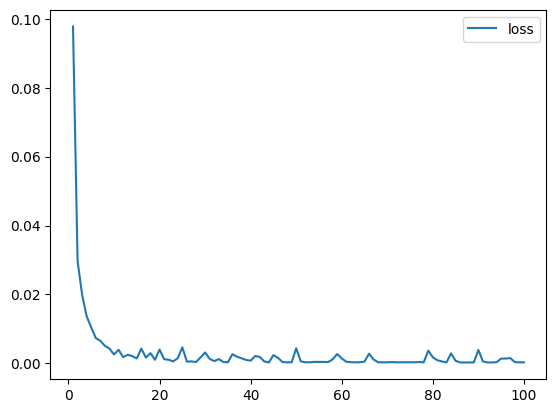

In [64]:
 # Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

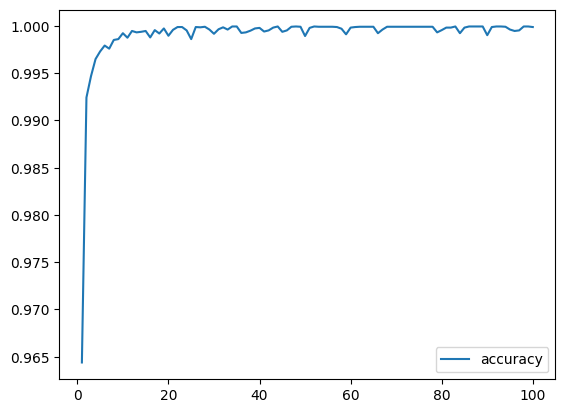

In [65]:
 # Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [66]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

351/351 - 1s - loss: 0.0648 - accuracy: 0.9955 - 979ms/epoch - 3ms/step
Loss: 0.06481697410345078, Accuracy: 0.9954565763473511


In [67]:
nn.save('Models/NewsPredictionmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model prediction

In [68]:
#Save and Load a machine learning model
import pickle

# Save the model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

# Load the model
with open("model.pkl", "rb") as f:
    model = pickle.load(f)


In [69]:
# The current working directory of the process
import os
print(os.getcwd())

/content


In [70]:
#test data
test_news =["Who knew that Obama would humiliate himself and us as soon as humanly possible with his trip to Asia? There was really no way to know that   this is one of the smartest men on the planet oh wait. This is Donald Trump. And in discussing North Korea s decision to fire ballistic missiles over Japan, he wondered why Japan didn t just shoot those missiles down.That, in turn, shows a complete and total lack of knowledge about how missiles work, about even our own military s capabilities, and about the optics of such an endeavor on ours and Japan s part. First off, it would have been extremely difficult for Japan to shoot them down due to their altitude and speed.",
            "The Weeknd’s Blinding Lights becomes 1st Spotify track to cross 4 billion streams: The Canadian singer’s hit song Blinding Lights has reached a new milestone on Spotify, becoming the first track to surpass 4 billion streams on the platform. The song, released in November 2019, also holds the record for the most weeks spent in the top five of the Billboard Hot 100 chart.",
            "NEW YORK/WASHINGTON (Reuters) - The new U.S. tax code targets high-tax states and may be unconstitutional, New York Governor Andrew Cuomo said on Thursday, saying that the bill may violate New York residentsâ€™ rights to due process and equal protection.  The sweeping Republican tax bill signed into law by U.S. President Donald Trump on Friday introduces a cap, of $10,000,  on deductions of state and local income and property taxes, known as SALT. The tax overhaul was the partyâ€™s first major legislative victory since Trump took office in January.  The SALT provision will hit many taxpayers in states with high incomes, high property values and high taxes, like New York, New Jersey and California. Those states are generally Democratic leaning.  â€œIâ€™m not even sure what they did is legally constitutional and thatâ€™s something weâ€™re looking at now,â€ Cuomo said in an interview with CNN. In an interview with CNBC, Cuomo suggested why the bill may be unconstitutional.  â€œPolitics does not trump the law,â€ Cuomo said on CNBC. â€œYou have the constitution, you have the law, you have due process, you have equal protection. You canâ€™t use politics just because the majority controls to override the law.â€ The Fifth Amendment of the Constitution, better known for its protection against self-incrimination, also protects individuals from seizure of life, liberty or property without due process and has been interpreted by the Supreme Court as guaranteeing equal protection by the law."
      ]

In [71]:
# Data save in Dataframe
news_dict = {'news': test_news}
df = pd.DataFrame(news_dict)

In [72]:
df.to_csv('news_data.csv', index=False)

In [73]:
# Load the trained model
loaded_model = pickle.load(open('model.pkl', 'rb'))

In [74]:
# Load the new dataset
new_data = pd.read_csv('news_data.csv')

In [75]:
# Preprocess the new dataset

# Define the function for text preprocessing
def preprocess_text(text):

    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    pattern_url = re.compile(r'(https?://\S+)|(www\.\S+)|(\S+\.\S+/\S+)')
    text = pattern_url.sub(r'', text)

    # Remove special characters
    pattern = r'[^\w\s]'
    text = re.sub(pattern, '', text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Lemmatize text
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])

    # Remove tokens
    # Remove repeating characters
    text = re.sub(r'(\w)\1+', r'\1', text)

    # Remove tokens containing digits
    text = re.sub(r'\b\w*\d\w*\b', '', text)

    # Remove tokens containing underscore
    text = re.sub(r'\b\w*_\w*\b', '', text)

    # Remove tokens containing special characters
    text = re.sub(r'\b\w*[^\w\s]+\w*\b', '', text)

    # Remove tokens less than 2 characters
    text = re.sub(r'\b\w{1}\b', '', text)

    return text

 # Apply the text preprocessing function to the dataset
new_data['news'] = new_data['news'].apply(preprocess_text)
new_data

,news
0,knew obama would humiliate son humanly posibl...
1,weknds blinding light becomes spotify track c...
2,new yorkwashington reuters new tax code targe...


In [76]:
# Define the tokenizer object
MAX_NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(new_data['news'])

# Make predictions using the loaded model
MAX_SEQUENCE_LENGTH = 101
testX = tokenizer.texts_to_sequences(new_data['news'])
testX = pad_sequences(testX, maxlen=MAX_SEQUENCE_LENGTH)
predictions = loaded_model.predict(testX)

#Create a new DataFrame to store the predictions along with the original text data
df_test = pd.DataFrame({'test_sent': new_data['news'], 'prediction': predictions})
df_test['test_sent'] = df_test['test_sent'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [77]:
#Classify the text data as “Fake” or “Real” based on the predicted probabilities
df_test['prediction'] = df_test['prediction'].apply(lambda x: "Fake" if x>=0.5 else "Real")
df_test

,test_sent,prediction
0,knew obama would humiliate son humanly posible...,Fake
1,weknds blinding light becomes spotify track cr...,Fake
2,new yorkwashington reuters new tax code target...,Real
